In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0-beta0
sys.version_info(major=3, minor=7, micro=0, releaselevel='final', serial=0)
matplotlib 3.0.3
numpy 1.16.0
pandas 0.24.2
sklearn 0.21.3
tensorflow 2.0.0-beta0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)


(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [5]:
# RandomizedSearchCV
# 1. 转化为sklearn的model
# 2. 定义参数集合
# 3. 搜索参数

def build_model(hidden_layers = 1,
                layer_size = 30,
                learning_rate = 3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu',
                                 input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size,
                                     activation = 'relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer)
    return model

sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(
    build_fn = build_model)
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
history = sklearn_model.fit(x_train_scaled, y_train,
                            epochs = 10,
                            validation_data = (x_valid_scaled, y_valid),
                            callbacks = callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 0s 28us/sample - loss: 1.2312 - val_loss: 0.7188
Epoch 2/10
11610/11610 [==============================] - 0s 21us/sample - loss: 0.6179 - val_loss: 0.6175
Epoch 3/10
11610/11610 [==============================] - 0s 21us/sample - loss: 0.5477 - val_loss: 0.5672
Epoch 4/10
11610/11610 [==============================] - 0s 20us/sample - loss: 0.5115 - val_loss: 0.5408
Epoch 5/10
11610/11610 [==============================] - 0s 21us/sample - loss: 0.4945 - val_loss: 0.5114
Epoch 6/10
11610/11610 [==============================] - 0s 20us/sample - loss: 0.4750 - val_loss: 0.4968
Epoch 7/10
11610/11610 [==============================] - 0s 20us/sample - loss: 0.4686 - val_loss: 0.4841
Epoch 8/10
11610/11610 [==============================] - 0s 20us/sample - loss: 0.4561 - val_loss: 0.4786
Epoch 9/10
11610/11610 [==============================] - 0s 20us/sample - loss: 0.4447 - val_l

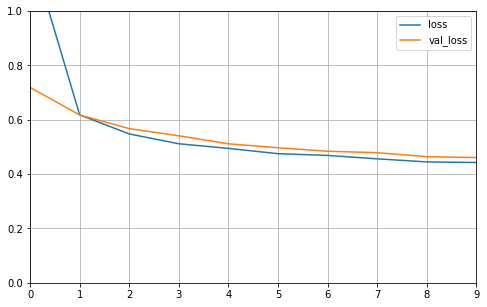

In [6]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [7]:
from scipy.stats import reciprocal
# f(x) = 1/(x*log(b/a)) a <= x <= b

param_distribution = {
    "hidden_layers":[1, 2, 3, 4],
    "layer_size": np.arange(1, 100),
    "learning_rate": reciprocal(1e-4, 1e-2),
}

from sklearn.model_selection import RandomizedSearchCV

random_search_cv = RandomizedSearchCV(sklearn_model,
                                      param_distribution,
                                      n_iter = 10,
                                      cv = 3,
                                      n_jobs = 1)
random_search_cv.fit(x_train_scaled, y_train, epochs = 100,
                     validation_data = (x_valid_scaled, y_valid),
                     callbacks = callbacks)

# cross_validation: 训练集分成n份，n-1训练，最后一份验证.

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 35us/sample - loss: 1.9303 - val_loss: 1.2728
Epoch 2/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.8050 - val_loss: 0.7677
Epoch 3/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.7031 - val_loss: 0.7203
Epoch 4/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.6648 - val_loss: 0.6815
Epoch 5/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.6373 - val_loss: 0.6574
Epoch 6/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.6102 - val_loss: 0.6280
Epoch 7/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.5881 - val_loss: 0.6068
Epoch 8/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.5665 - val_loss: 0.5848
Epoch 9/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.5507 - val_loss: 0.568

3870/3870 [==============================] - 0s 11us/sample - loss: 0.3780
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 36us/sample - loss: 1.7608 - val_loss: 0.8252
Epoch 2/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.6869 - val_loss: 0.7049
Epoch 3/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.6171 - val_loss: 0.6647
Epoch 4/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.5838 - val_loss: 0.6321
Epoch 5/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5575 - val_loss: 0.6066
Epoch 6/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.5361 - val_loss: 0.5848
Epoch 7/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.5174 - val_loss: 0.5645
Epoch 8/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.5009 - val_loss: 0.5498
Epoch 9/100
7740/7740 [======

7740/7740 [==============================] - 0s 23us/sample - loss: 0.5334 - val_loss: 0.5614
Epoch 37/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.5298 - val_loss: 0.5576
Epoch 38/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.5262 - val_loss: 0.5537
Epoch 39/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.5229 - val_loss: 0.5502
Epoch 40/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.5197 - val_loss: 0.5466
Epoch 41/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.5166 - val_loss: 0.5431
Epoch 42/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.5138 - val_loss: 0.5401
Epoch 43/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.5110 - val_loss: 0.5371
Epoch 44/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.5083 - val_loss: 0.5344
Epoch 45/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 23us/sample - loss: 0.4886 - val_loss: 0.5230
Epoch 53/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.4867 - val_loss: 0.5206
Epoch 54/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.4850 - val_loss: 0.5185
Epoch 55/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.4833 - val_loss: 0.5165
Epoch 56/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.4817 - val_loss: 0.5145
Epoch 57/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.4800 - val_loss: 0.5123
Epoch 58/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.4786 - val_loss: 0.5104
Epoch 59/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.4772 - val_loss: 0.5091
Epoch 60/100
7740/7740 [==============================] - 0s 22us/sample - loss: 0.4757 - val_loss: 0.5074
Epoch 61/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 36us/sample - loss: 4.7452 - val_loss: 4.1744
Epoch 2/100
7740/7740 [==============================] - 0s 24us/sample - loss: 3.4435 - val_loss: 3.1087
Epoch 3/100
7740/7740 [==============================] - 0s 25us/sample - loss: 2.6047 - val_loss: 2.4187
Epoch 4/100
7740/7740 [==============================] - 0s 25us/sample - loss: 2.0638 - val_loss: 1.9757
Epoch 5/100
7740/7740 [==============================] - 0s 25us/sample - loss: 1.7133 - val_loss: 1.6838
Epoch 6/100
7740/7740 [==============================] - 0s 26us/sample - loss: 1.4822 - val_loss: 1.4904
Epoch 7/100
7740/7740 [==============================] - 0s 24us/sample - loss: 1.3264 - val_loss: 1.3562
Epoch 8/100
7740/7740 [==============================] - 0s 24us/sample - loss: 1.2162 - val_loss: 1.2579
Epoch 9/100
7740/7740 [==============================] - 0s 24us/sample - loss: 1.1342 - val_loss: 1.1821
Epoch 10/100
7740/7740 [==============================] - 

7740/7740 [==============================] - ETA: 0s - loss: 0.558 - 0s 25us/sample - loss: 0.5574 - val_loss: 0.5856
Epoch 78/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.5556 - val_loss: 0.5836
Epoch 79/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5539 - val_loss: 0.5816
Epoch 80/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.5521 - val_loss: 0.5797
Epoch 81/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.5504 - val_loss: 0.5777
Epoch 82/100
3870/3870 [==============================] - 0s 11us/sample - loss: 0.5038
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 36us/sample - loss: 4.3542 - val_loss: 3.8240
Epoch 2/100
7740/7740 [==============================] - 0s 25us/sample - loss: 3.1677 - val_loss: 2.8497
Epoch 3/100
7740/7740 [==============================] - 0s 25us/sample - loss: 2.4113 - val_loss: 2.2248


7740/7740 [==============================] - 0s 25us/sample - loss: 0.5539 - val_loss: 0.6046
Epoch 71/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5520 - val_loss: 0.6025
Epoch 72/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5502 - val_loss: 0.6004
Epoch 73/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.5484 - val_loss: 0.5984
Epoch 74/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5466 - val_loss: 0.5964
Epoch 75/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.5448 - val_loss: 0.5945
Epoch 76/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5431 - val_loss: 0.5925
Epoch 77/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.5414 - val_loss: 0.5906
Epoch 78/100
3870/3870 [==============================] - 0s 10us/sample - loss: 0.5486
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740

7740/7740 [==============================] - 0s 25us/sample - loss: 0.5346 - val_loss: 0.5977
Epoch 68/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5328 - val_loss: 0.5957
Epoch 69/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5311 - val_loss: 0.5938
Epoch 70/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.5294 - val_loss: 0.5918
Epoch 71/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5278 - val_loss: 0.5899
Epoch 72/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5261 - val_loss: 0.5880
Epoch 73/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5245 - val_loss: 0.5861
Epoch 74/100
3870/3870 [==============================] - 0s 10us/sample - loss: 0.5736
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 40us/sample - loss: 4.3810 - val_loss: 4.0640
Epoch 2/100
7740/7740 

7740/7740 [==============================] - 0s 26us/sample - loss: 0.6332 - val_loss: 0.6632
Epoch 69/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.6298 - val_loss: 0.6597
Epoch 70/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.6263 - val_loss: 0.6562
Epoch 71/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.6229 - val_loss: 0.6528
Epoch 72/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.6196 - val_loss: 0.6494
Epoch 73/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.6162 - val_loss: 0.6460
Epoch 74/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.6129 - val_loss: 0.6426
Epoch 75/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.6097 - val_loss: 0.6393
Epoch 76/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.6065 - val_loss: 0.6360
Epoch 77/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 26us/sample - loss: 0.5362 - val_loss: 0.5667
Epoch 44/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.5337 - val_loss: 0.5640
Epoch 45/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.5313 - val_loss: 0.5613
Epoch 46/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.5289 - val_loss: 0.5587
Epoch 47/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.5266 - val_loss: 0.5562
Epoch 48/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.5243 - val_loss: 0.5536
Epoch 49/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5221 - val_loss: 0.5512
Epoch 50/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.5198 - val_loss: 0.5488
Epoch 51/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5177 - val_loss: 0.5464
Epoch 52/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 26us/sample - loss: 0.5917 - val_loss: 0.6475
Epoch 51/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5879 - val_loss: 0.6438
Epoch 52/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5843 - val_loss: 0.6400
Epoch 53/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.5807 - val_loss: 0.6364
Epoch 54/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.5771 - val_loss: 0.6329
Epoch 55/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.5738 - val_loss: 0.6295
Epoch 56/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5705 - val_loss: 0.6263
Epoch 57/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5673 - val_loss: 0.6232
Epoch 58/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.5643 - val_loss: 0.6201
Epoch 59/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 27us/sample - loss: 0.5456 - val_loss: 0.5696
Epoch 44/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.5423 - val_loss: 0.5663
Epoch 45/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.5392 - val_loss: 0.5631
Epoch 46/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.5361 - val_loss: 0.5598
Epoch 47/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.5331 - val_loss: 0.5566
Epoch 48/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.5302 - val_loss: 0.5536
Epoch 49/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.5273 - val_loss: 0.5506
Epoch 50/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.5245 - val_loss: 0.5477
Epoch 51/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.5217 - val_loss: 0.5448
Epoch 52/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 27us/sample - loss: 0.5476 - val_loss: 0.5896
Epoch 45/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.5443 - val_loss: 0.5859
Epoch 46/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.5411 - val_loss: 0.5824
Epoch 47/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.5379 - val_loss: 0.5791
Epoch 48/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.5348 - val_loss: 0.5755
Epoch 49/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.5318 - val_loss: 0.5721
Epoch 50/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.5288 - val_loss: 0.5690
Epoch 51/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.5258 - val_loss: 0.5657
Epoch 52/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.5230 - val_loss: 0.5627
Epoch 53/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 27us/sample - loss: 0.4973 - val_loss: 0.5506
Epoch 39/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.4940 - val_loss: 0.5468
Epoch 40/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.4908 - val_loss: 0.5432
Epoch 41/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.4877 - val_loss: 0.5396
Epoch 42/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.4847 - val_loss: 0.5363
Epoch 43/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4818 - val_loss: 0.5329
Epoch 44/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.4789 - val_loss: 0.5296
Epoch 45/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.4762 - val_loss: 0.5264
Epoch 46/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.4735 - val_loss: 0.5233
Epoch 47/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 28us/sample - loss: 0.2989 - val_loss: 0.3160
Epoch 21/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.2969 - val_loss: 0.3349
Epoch 22/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.2946 - val_loss: 0.3609
Epoch 23/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.2944 - val_loss: 0.3311
Epoch 24/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.2896 - val_loss: 0.3214
Epoch 25/100
3870/3870 [==============================] - 0s 12us/sample - loss: 0.2902
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 43us/sample - loss: 1.1277 - val_loss: 1.0776
Epoch 2/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.7438 - val_loss: 0.5049
Epoch 3/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.4637 - val_loss: 0.4591
Epoch 4/100
7740/7740 [=

7740/7740 [==============================] - 0s 26us/sample - loss: 0.5313 - val_loss: 0.5291
Epoch 3/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.4544 - val_loss: 0.4604
Epoch 4/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.4131 - val_loss: 0.4311
Epoch 5/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.3881 - val_loss: 0.4045
Epoch 6/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.3751 - val_loss: 0.3916
Epoch 7/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.3649 - val_loss: 0.3821
Epoch 8/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.3542 - val_loss: 0.3751
Epoch 9/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.3467 - val_loss: 0.3681
Epoch 10/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.3422 - val_loss: 0.3631
Epoch 11/100
7740/7740 [==============================] -

7740/7740 [==============================] - 0s 26us/sample - loss: 0.3549 - val_loss: 0.3808
Epoch 8/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.3509 - val_loss: 0.3786
Epoch 9/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.3445 - val_loss: 0.3709
Epoch 10/100
7740/7740 [==============================] - 0s 27us/sample - loss: 0.3412 - val_loss: 0.3712
Epoch 11/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.3361 - val_loss: 0.3663
Epoch 12/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.3300 - val_loss: 0.3630
Epoch 13/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.3255 - val_loss: 0.3702
Epoch 14/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.3269 - val_loss: 0.3601
Epoch 15/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.3234 - val_loss: 0.3561
Epoch 16/100
7740/7740 [============================

3870/3870 [==============================] - 0s 11us/sample - loss: 0.3996
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 38us/sample - loss: 3.4305 - val_loss: 1.8802
Epoch 2/100
7740/7740 [==============================] - 0s 25us/sample - loss: 1.2930 - val_loss: 1.0516
Epoch 3/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.9044 - val_loss: 0.8830
Epoch 4/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.7932 - val_loss: 0.8153
Epoch 5/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.7410 - val_loss: 0.7790
Epoch 6/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.7114 - val_loss: 0.7532
Epoch 7/100
7740/7740 [==============================] - 0s 26us/sample - loss: 0.6893 - val_loss: 0.7314
Epoch 8/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.6709 - val_loss: 0.7125
Epoch 9/100
7740/7740 [======

7740/7740 [==============================] - 0s 24us/sample - loss: 0.5134 - val_loss: 0.5651
Epoch 23/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.5076 - val_loss: 0.5599
Epoch 24/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.5027 - val_loss: 0.5533
Epoch 25/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.4975 - val_loss: 0.5477
Epoch 26/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.4924 - val_loss: 0.5423
Epoch 27/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.4877 - val_loss: 0.5371
Epoch 28/100
7740/7740 [==============================] - 0s 24us/sample - loss: 0.4832 - val_loss: 0.5324
Epoch 29/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.4787 - val_loss: 0.5273
Epoch 30/100
7740/7740 [==============================] - 0s 25us/sample - loss: 0.4743 - val_loss: 0.5226
Epoch 31/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 24us/sample - loss: 0.4469 - val_loss: 0.4650
Epoch 36/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.4449 - val_loss: 0.4633
Epoch 37/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.4424 - val_loss: 0.4604
Epoch 38/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.4407 - val_loss: 0.4588
Epoch 39/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.4387 - val_loss: 0.4569
Epoch 40/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.4367 - val_loss: 0.4542
Epoch 41/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.4351 - val_loss: 0.4524
Epoch 42/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.4333 - val_loss: 0.4507
Epoch 43/100
7740/7740 [==============================] - 0s 22us/sample - loss: 0.4316 - val_loss: 0.4485
Epoch 44/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 23us/sample - loss: 0.4513 - val_loss: 0.4921
Epoch 28/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.4485 - val_loss: 0.4888
Epoch 29/100
7740/7740 [==============================] - 0s 22us/sample - loss: 0.4458 - val_loss: 0.4854
Epoch 30/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.4433 - val_loss: 0.4828
Epoch 31/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.4409 - val_loss: 0.4794
Epoch 32/100
7740/7740 [==============================] - 0s 22us/sample - loss: 0.4385 - val_loss: 0.4767
Epoch 33/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.4360 - val_loss: 0.4743
Epoch 34/100
7740/7740 [==============================] - 0s 23us/sample - loss: 0.4340 - val_loss: 0.4724
Epoch 35/100
7740/7740 [==============================] - 0s 22us/sample - loss: 0.4320 - val_loss: 0.4701
Epoch 36/100
7740/7740 [==========================

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x00000286E6CC88D0>,
                   iid='warn', n_iter=10, n_jobs=1,
                   param_distributions={'hidden_layers': [1, 2, 3, 4],
                                        'layer_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36...7, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000286EA2CE1D0>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_sc

In [ ]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)

In [ ]:
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print("GPU Available: ", tf.test.is_gpu_available())

GPU Available:  False
